# <font color=red><center>**My Content : Books recommandation mobile app**</center></font>

# <font color=red><center>**Collaborative Filtering with Surprise**</font>

## **<font color=green>Dataset</font>**
We will work with the Globo.com 

The dataset is composed of the following files :

- clicks/clicks/ : contains 385 CSV files
- clicks_hour_*.csv : contains one hour of clicks on the website
- articles_embeddings.pickle : pickle file containing the embeddings of the articles
- articles_metadata.csv : CSV file containing the metadata of the articles

# <font color=salmon>PART 1 - LIBRARIES, PARAMETERS AND HELPERS</font>

## **<font color=green>Loading libraries</font>**

In [2]:
import os
import sys

# Add source directory to python path
sys.path.append(os.path.abspath("../"))


import logging
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
# import src.data.helpers as data_helpers
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler
from surprise import (
    NMF,
    SVD,
    BaselineOnly,
    CoClustering,
    Dataset,
    KNNBaseline,
    KNNBasic,
    KNNWithMeans,
    KNNWithZScore,
    NormalPredictor,
    Reader,
    SlopeOne,
    SVDpp,
)
from surprise.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split,
)
from tqdm import tqdm

# Plotly as Pandas plotting backend
pd.options.plotting.backend = "plotly"

# Surprise ratings reader
reader = Reader(rating_scale=(0, 1))

RAW_DATA_PATH = "../data"

CACHE = dict()

In [3]:
def reduce_dataframe_memory_usage(
    df: pd.DataFrame,
    high_precision: bool = False,
) -> pd.DataFrame:
    """
    Iterate through all the columns of a dataframe and modify the data type to
    reduce memory usage.
    Args:
        df (pd.DataFrame): dataframe to reduce memory usage.
        high_precision (bool): If True, use 64-bit floats instead of 32-bit
    Returns:
        pd.DataFrame: dataframe with reduced memory usage.
    """
    start_mem = round(df.memory_usage().sum() / 1024**2, 2)
    logging.info("Memory usage of dataframe is %d MB", start_mem)

    # Iterate through columns
    for col in df.columns:
        if df[col].dtype == "object":
            # "object" dtype
            if df[col].nunique() < max(100, df.shape[0] / 100):
                # If number of unique values is less than max(100, 1%)
                df[col] = df[col].astype("category")
            else:
                # If number of unique values is greater than max(100, 1%)
                df[col] = df[col].astype("string")

        elif str(df[col].dtype)[:3] == "int":
            # "int" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df[col] = df[col].astype("UInt8")
            elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype("Int8")
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df[col] = df[col].astype("UInt16")
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype("Int16")
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df[col] = df[col].astype("UInt32")
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype("Int32")
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                df[col] = df[col].astype("UInt64")
            else:
                df[col] = df[col].astype("Int64")

        elif str(df[col].dtype)[:5] == "float":
            # "float" dtype
            c_min = df[col].min()
            c_max = df[col].max()
            if (
                not high_precision
                and c_min > np.finfo(np.float32).min
                and c_max < np.finfo(np.float32).max
            ):
                df[col] = df[col].astype("float32")
            else:
                df[col] = df[col].astype("float64")

    end_mem = round(df.memory_usage().sum() / 1024**2, 2)
    logging.info("Memory usage after optimization is %d MB", end_mem)
    if start_mem > 0:
        logging.info(
            "Decreased by %d %%", round(100 * (start_mem - end_mem) / start_mem)
        )

    return df

In [4]:
NUM_EMBEDDINGS = 250

articles = pd.concat(
    [
        pd.read_csv(
            Path(RAW_DATA_PATH, "articles_metadata.csv"),
            parse_dates=["created_at_ts"],
            date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
            dtype={
                "article_id": "category",
                "category_id": "category",
                "publisher_id": "category",
                "words_count": "int",
            },
        ),
        pd.DataFrame(
            pd.read_pickle(Path(RAW_DATA_PATH, "articles_embeddings.pickle")),
            columns=["embedding_" + str(i) for i in range(NUM_EMBEDDINGS)],
        ),
    ],
    axis=1,
)

articles = reduce_dataframe_memory_usage(
    articles.astype({"created_at_ts": "datetime64[ns]"})
)

articles_sample = articles.sample(frac=0.01, random_state=42)

articles.describe(include="all", datetime_is_numeric=True)

article_id category_id                  created_at_ts publisher_id  \
count      364047      364047                         364047       364047   
unique     364047         461                            NaN            1   
top             0         281                            NaN            0   
freq            1       12817                            NaN       364047   
mean          NaN         NaN  2016-09-17 01:25:54.949498624          NaN   
min           NaN         NaN            2006-09-27 13:14:35          NaN   
25%           NaN         NaN     2015-10-15 18:00:43.500000          NaN   
50%           NaN         NaN            2017-03-13 17:27:29          NaN   
75%           NaN         NaN            2017-11-05 15:09:11          NaN   
max           NaN         NaN            2018-03-13 13:12:30          NaN   
std           NaN         NaN                            NaN          NaN   

          words_count    embedding_0    embedding_1    embedding_2  \
count   364047.000000  364047.000000  364047.000000  364047.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean       190.897727      -0.238645      -0.963335       0.118548   
min          0.000000      -0.991183      -0.996455      -0.968431   
25%        159.000000      -0.620072      -0.974056      -0.289953   
50%        186.000000      -0.302581      -0.967605       0.124339   
75%        218.000000       0.098015      -0.959061       0.545112   
max       6690.000000       0.983694      -0.514728       0.998341   
std         59.502766       0.451497       0.022651       0.495050   

          embedding_3    embedding_4  ...  embedding_240  embedding_241  \
count   364047.000000  364047.000000  ...  364047.000000  364047.000000   
unique            NaN            NaN  ...            NaN            NaN   
top               NaN            NaN  ...            NaN            NaN   
freq              NaN            NaN  ...            NaN            NaN   
mean        -0.279295      -0.068579  ...      -0.133287      -0.081912   
min         -0.994966      -0.994489  ...      -0.990412      -0.989408   
25%         -0.718816      -0.503425  ...      -0.547684      -0.445079   
50%         -0.391535      -0.093734  ...      -0.175781      -0.094113   
75%          0.108320       0.345024  ...       0.250641       0.270006   
max          0.978092       0.996798  ...       0.996401       0.981789   
std          0.505067       0.506723  ...       0.490597       0.449957   

        embedding_242  embedding_243  embedding_244  embedding_245  \
count   364047.000000  364047.000000  364047.000000  364047.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean        -0.060347       0.023003       0.076947       0.084603   
min         -0.990432      -0.993626      -0.989042      -0.996902   
25%         -0.479989      -0.404508      -0.248653      -0.267072   
50%         -0.078034       0.000726       0.105649       0.133525   
75%          0.341105       0.459386       0.417347       0.461466   
max          0.991332       0.995299       0.978823       0.989324   
std          0.489498       0.507181       0.426143       0.467998   

        embedding_246  embedding_247  embedding_248  embedding_249  
count   364047.000000  364047.000000  364047.000000  364047.000000  
unique            NaN            NaN            NaN            NaN  
top               NaN            NaN            NaN            NaN  
freq              NaN            NaN            NaN            NaN  
mean         0.062819       0.099768       0.155917      -0.041094  
min         -0.992921      -0.984733      -0.976071      -0.988213  
25%         -0.3

In [5]:
clicks = pd.concat(
    [
        pd.read_csv(
            click_file_path,
            parse_dates=["session_start", "click_timestamp"],
            date_parser=lambda x: datetime.fromtimestamp(int(int(x) / 1000)),
            dtype={
                "user_id": "category",
                "session_id": "category",
                "session_size": "int",
                "click_article_id": "category",
                "click_environment": "category",
                "click_deviceGroup": "category",
                "click_os": "category",
                "click_country": "category",
                "click_region": "category",
                "click_referrer_type": "category",
            },
        ).replace(
            {
                "click_environment": {
                    "1": "1 - Facebook Instant Article",
                    "2": "2 - Mobile App",
                    "3": "3 - AMP (Accelerated Mobile Pages)",
                    "4": "4 - Web",
                },
                "click_deviceGroup": {
                    "1": "1 - Tablet",
                    "2": "2 - TV",
                    "3": "3 - Empty",
                    "4": "4 - Mobile",
                    "5": "5 - Desktop",
                },
                "click_os": {
                    "1": "1 - Other",
                    "2": "2 - iOS",
                    "3": "3 - Android",
                    "4": "4 - Windows Phone",
                    "5": "5 - Windows Mobile",
                    "6": "6 - Windows",
                    "7": "7 - Mac OS X",
                    "8": "8 - Mac OS",
                    "9": "9 - Samsung",
                    "10": "10 - FireHbbTV",
                    "11": "11 - ATV OS X",
                    "12": "12 - tvOS",
                    "13": "13 - Chrome OS",
                    "14": "14 - Debian",
                    "15": "15 - Symbian OS",
                    "16": "16 - BlackBerry OS",
                    "17": "17 - Firefox OS",
                    "18": "18 - Android",
                    "19": "19 - Brew MP",
                    "20": "20 - Chromecast",
                    "21": "21 - webOS",
                    "22": "22 - Gentoo",
                    "23": "23 - Solaris",
                },
            }
        )
        for click_file_path in tqdm(
            sorted(Path(RAW_DATA_PATH, "clicks/clicks").glob("clicks_hour_*.csv"))
        )
    ],
    sort=False,
    ignore_index=True,
    verify_integrity=True,
)

clicks = reduce_dataframe_memory_usage(
    clicks.astype(
        {"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"}
    )
)

clicks.describe(include="all", datetime_is_numeric=True)

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:37<00:00, 10.33it/s]


user_id        session_id                  session_start  \
count   2988181           2988181                        2988181   
unique   322897           1048594                            NaN   
top        5890  1507563657895091                            NaN   
freq       1232               124                            NaN   
mean        NaN               NaN  2017-10-08 16:17:08.013155328   
min         NaN               NaN            2017-10-01 04:37:03   
25%         NaN               NaN            2017-10-04 15:35:52   
50%         NaN               NaN            2017-10-08 22:09:00   
75%         NaN               NaN            2017-10-11 21:16:54   
max         NaN               NaN            2017-10-17 05:36:19   
std         NaN               NaN                            NaN   

        session_size click_article_id                click_timestamp  \
count   2.988181e+06          2988181                        2988181   
unique           NaN            46033                            NaN   
top              NaN           160974                            NaN   
freq             NaN            37213                            NaN   
mean    3.901885e+00              NaN  2017-10-08 16:51:05.070374400   
min     2.000000e+00              NaN            2017-10-01 05:00:00   
25%     2.000000e+00              NaN            2017-10-04 16:20:52   
50%     3.000000e+00              NaN            2017-10-08 22:35:30   
75%     4.000000e+00              NaN            2017-10-11 21:43:24   
max     1.240000e+02              NaN            2017-11-13 21:04:14   
std     3.929941e+00              NaN                            NaN   

       click_environment click_deviceGroup         click_os click_country  \
count            2988181           2988181          2988181       2988181   
unique                 3                 5                8            11   
top              4 - Web        1 - Tablet  17 - Firefox OS             1   
freq             2904478           1823162          1738138       2852406   
mean                 NaN               NaN              NaN           NaN   
min                  NaN               NaN              NaN           NaN   
25%                  NaN               NaN              NaN           NaN   
50%                  NaN               NaN              NaN           NaN   
75%                  NaN               NaN              NaN           NaN   
max                  NaN               NaN              NaN           NaN   
std                  NaN               NaN              NaN           NaN   

       click_region click_referrer_type  
count       2988181             2988181  
unique           28                   7  
top              25                   2  
freq         804985             1602601  
mean            NaN                 NaN  
min             NaN                 NaN  
25%             NaN                 NaN  
50%             NaN                 NaN  
75%             NaN                 NaN  
max             NaN                 NaN  
std             NaN                 NaN

### Implicit ranking

Without an explicit rating of the articles by the users, we must model an implicit rating

In [6]:
def get_ratings_from_clicks(clicks):
    count_user_article_clicks = (
        clicks.reset_index()
        .groupby(["user_id", "click_article_id"])
        .agg(
            COUNT_user_article_clicks=("index", "count"),
        )
    )

    count_user_clicks = (
        clicks.reset_index()
        .groupby(["user_id"])
        .agg(
            COUNT_user_clicks=("index", "count"),
        )
    )

    ratings = count_user_article_clicks.join(count_user_clicks, on="user_id")
    ratings["rating"] = (
        ratings["COUNT_user_article_clicks"] / ratings["COUNT_user_clicks"]
    )

    ratings = reduce_dataframe_memory_usage(
        ratings["rating"]
        .reset_index()
        .rename({"click_article_id": "article_id"}, axis=1)
    )

    return ratings


ratings = get_ratings_from_clicks(clicks)

ratings_sample = ratings.sample(frac=0.01, random_state=42)

ratings

user_id article_id    rating
0             0     157541  0.125000
1             0     160158  0.125000
2             0     233470  0.125000
3             0     313996  0.125000
4             0      68866  0.125000
...         ...        ...       ...
2950705   99998      64329  0.071429
2950706   99999     168784  0.250000
2950707   99999     225055  0.250000
2950708   99999     272143  0.250000
2950709   99999      50644  0.250000

[2950710 rows x 3 columns]

### k-fold Cross-Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. 

The general procedure is as follows:

* Shuffle the dataset randomly.
* Split the dataset into k groups
* For each unique group:
    * Take the group as a hold out or test data set
    * Take the remaining groups as a training data set
    * Fit a model on the training set and evaluate it on the test set
    * Retain the evaluation score and discard the model
* Summarize the skill of the model using the sample of model evaluation scores

In [7]:
sample_frac = 0.25

data = Dataset.load_from_df(ratings.sample(frac=sample_frac, random_state=42), reader)

for algo in [
    NormalPredictor(),  # bad results
    BaselineOnly(),
    # KNNBasic(), # uses too much memory
    # KNNWithMeans(), # uses too much memory
    # KNNWithZScore(), # uses too much memory
    # KNNBaseline(), # uses too much memory
    SVD(),
    SVDpp(),
    # NMF(),  # long training time
    # SlopeOne(),  # uses too much memory
    CoClustering(),  #
]:
    print("v" * (len(algo.__class__.__name__) + 4))
    print("> " + algo.__class__.__name__ + " <")
    print("^" * (len(algo.__class__.__name__) + 4))

    # Run 5-fold cross-validation and print results
    cross_validate(algo, data, verbose=True)
    print()

vvvvvvvvvvvvvvvvvvv
> NormalPredictor <
^^^^^^^^^^^^^^^^^^^
Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1693  0.1697  0.1696  0.1694  0.1697  0.1695  0.0002  
MAE (testset)     0.1269  0.1270  0.1269  0.1270  0.1271  0.1270  0.0001  
Fit time          0.83    1.15    1.15    1.16    1.16    1.09    0.13    
Test time         0.98    1.24    1.24    1.24    0.94    1.13    0.14    

vvvvvvvvvvvvvvvv
> BaselineOnly <
^^^^^^^^^^^^^^^^
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1167  0.1161  0.1155  0.1161  0.1165  0.1162  0.0004  
MAE (testset)     0.0786  0.0784  0.0780  0.0782  0.0785  0.0783  0.0002  
Fit 

#### GridSearchCV:
The module we will be utilizing is sklearn’s GridSearchCV, which will allow us to pass our specific estimator, our grid of parameters, and our chosen number of cross validation folds. The documentation for this method can be found here. Some of the main parameters are highlighted below:

* **estimator:** this parameter allows you to select the specific model you’re choosing to run, in our case Random Forest Classification.
* **param_grid:** this parameter allows you to pass the grid of parameters you are searching. This grid must be formatted as a dictionary with the key corresponding to the specific estimator’s parameter names, and the values corresponding to a list of values to pass for the specific parameters.
* **cv**: this parameter allows you to change the number of folds for the cross validation.

In [8]:
sample_frac = 0.1

data = Dataset.load_from_df(ratings.sample(frac=sample_frac, random_state=42), reader)


param_grid = {
    "n_factors": [20, 50, 100],  # 100
    "n_epochs": [20, 50, 100],  # 20
    "lr_all": [0.005, 0.01, 0.02],  # lr_all --> learning rate for all parameters
    "reg_all": [0.02, 0.05, 0.1],  # reg_all --> The regularization term for all parameters
}


grid = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=3,
    refit=True,
    return_train_measures=True,
    n_jobs=-2,
    joblib_verbose=9,
)

grid.fit(data)

# best RMSE score
print(grid.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(grid.best_params["rmse"])

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-2)]: Done  54 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  80 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done 110 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 144 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-2)]: Done 224 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-2)]: Done 243 out of 243 | elapsed:  9.1min finished


0.10452247498524407
{'n_factors': 20, 'n_epochs': 100, 'lr_all': 0.02, 'reg_all': 0.02}


In [9]:
model_baseline_only = BaselineOnly(verbose=True).fit(
    Dataset.load_from_df(ratings, reader).build_full_trainset()
)
model_svd = SVD(**grid.best_params["rmse"], random_state=42, verbose=True).fit(
    Dataset.load_from_df(ratings, reader).build_full_trainset()
)

Estimating biases using als...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48

### Models for user's preferences

We tested 3 different models to check user's preferences
* Last-clicked article
* Average of user's clicked articles over last session
* Average of all clicked articles

In [10]:
def aggregate_articles(articles):
    return articles.groupby(lambda x: True).agg(
        {
            col: "mean"
            if is_numeric_dtype(articles.dtypes[col])
            else lambda x: x.mode()[0]
            for col in articles.columns
        }
    )


def get_user_interest(user_id, clicks, articles, strategy="last_click"):
    user_id = str(user_id)

    if strategy == "last_click":
        last_clicked_article_id = (
            clicks.query("user_id == @user_id")
            .sort_values("click_timestamp", ascending=False)
            .reset_index(drop=True)
            .iloc[0]["click_article_id"]
        )
        interest = articles.query("article_id == @last_clicked_article_id")

    elif strategy == "last_session":
        last_session_id = (
            clicks.query("user_id == @user_id")
            .sort_values("click_timestamp", ascending=False)
            .reset_index(drop=True)
            .iloc[0]["session_id"]
        )
        session_article_ids = clicks.query("session_id == @last_session_id")[
            "click_article_id"
        ]
        interest = aggregate_articles(
            articles.query("article_id in @session_article_ids")
        ).drop(["article_id"], axis=1)

    elif strategy == "all_clicks":
        all_article_ids = clicks.query("user_id == @user_id")["click_article_id"]
        interest = aggregate_articles(
            articles.query("article_id in @all_article_ids")
        ).drop(["article_id"], axis=1)

    else:
        raise NotImplementedError

    return interest


def prepare_for_scale(articles, category_id):
    articles_copy = articles.drop(["article_id", "similarity"], axis=1, errors="ignore")
    articles_copy["category_id"] = articles_copy["category_id"].apply(
        lambda x: category_id if int(x) == category_id else 0
    )
    articles_copy["created_at_ts"] = articles_copy["created_at_ts"].apply(
        lambda x: x.value
    )

    return articles_copy


def get_closest_articles(interest, articles, n=10):
    category_id = interest["category_id"].iloc[0]

    scaler = StandardScaler()
    articles_std = scaler.fit_transform(prepare_for_scale(articles, category_id))
    interest_std = scaler.transform(prepare_for_scale(interest, category_id))

    articles = articles.copy()
    articles["similarity"] = cosine_similarity(interest_std, articles_std)[0]

    return (
        articles.sort_values("similarity", ascending=False).iloc[:n],
        scaler,
        articles_std,
        interest_std,
    )


def get_collaborative_reco(user_id, model, articles, n=10):
    return list(
        pd.DataFrame(
            [
                (
                    lambda p: {
                        "article_id": p.iid,
                        "prediction": p.est,
                    }
                )(model.predict(uid=user_id, iid=article_id))
                for article_id in articles["article_id"]
            ],
            columns=["article_id", "prediction"],
        )
        .sort_values(by="prediction", ascending=False)
        .reset_index(drop=True)["article_id"]
    )[:n]

In [11]:
user_id = "11183"

interest = get_user_interest(user_id, clicks, articles, strategy="all_clicks")
category_id = interest["category_id"].iloc[0]

closest_article_ids = get_collaborative_reco(user_id, model_baseline_only, articles)

scaler = StandardScaler()
articles_std = scaler.fit_transform(prepare_for_scale(articles, category_id))
articles_sample_std = scaler.transform(prepare_for_scale(articles_sample, category_id))

interest_std = scaler.transform(prepare_for_scale(interest, category_id))

closest_articles = articles[articles["article_id"].isin(closest_article_ids)]
closest_articles_std = scaler.transform(
    prepare_for_scale(closest_articles, category_id)
)

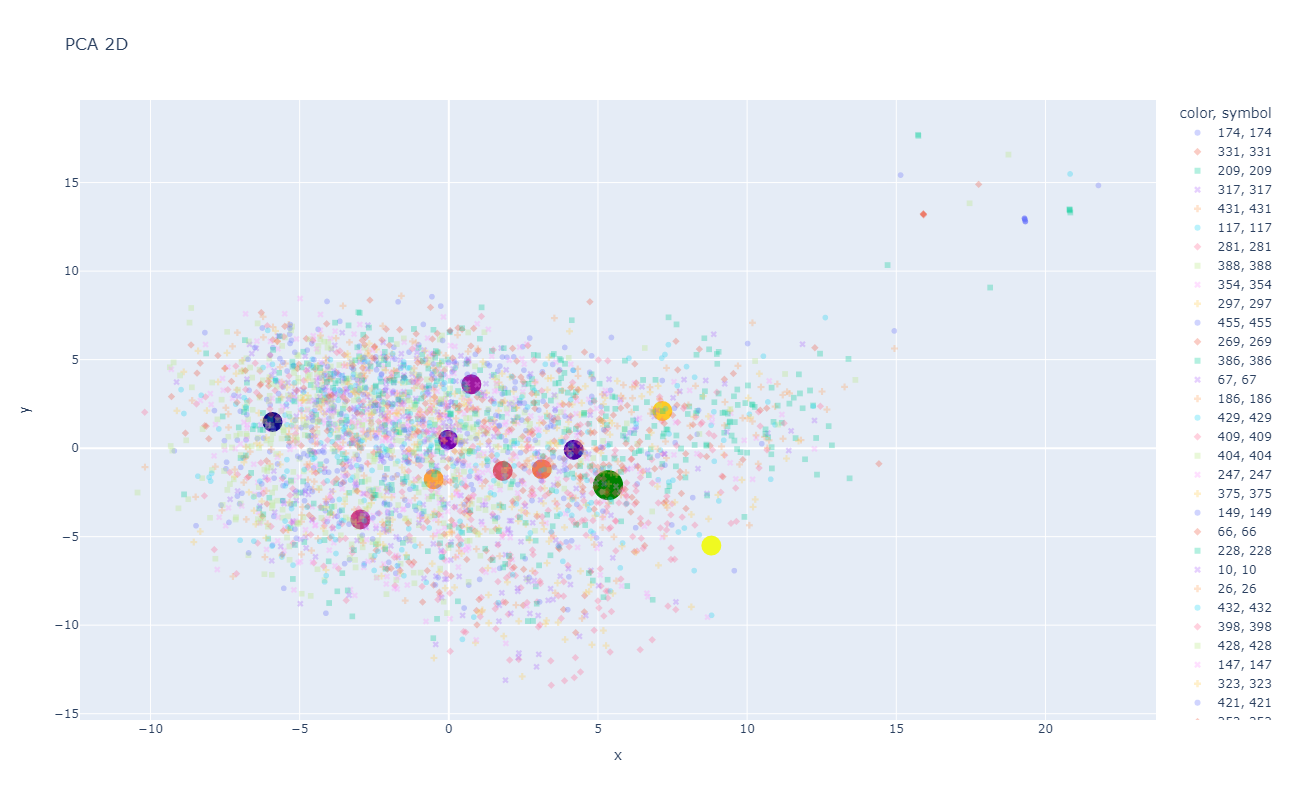

In [12]:
pca = PCA(n_components=2)
articles_pca = pca.fit_transform(articles_sample_std)
interest_pca = pca.transform(interest_std)
closest_articles_pca = pca.transform(closest_articles_std)


# Plot the data in the PCA space
fig = px.scatter(
    x=articles_pca[:, 0],
    y=articles_pca[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="PCA 2D",
    opacity=0.3,
    width=1200,
    height=800,
)
fig.add_scatter(
    x=interest_pca[:, 0],
    y=interest_pca[:, 1],
    mode="markers",
    marker=dict(color="green", size=30),
    text=f"User interest \n user_id: {user_id} \n category_id: {interest['category_id'].iloc[0]}",
)
fig.add_scatter(
    x=closest_articles_pca[:, 0],
    y=closest_articles_pca[:, 1],
    mode="markers",
    marker=dict(color=list(range(len(closest_articles_pca))), size=20),
    text=[
        f"rank: {i} / article_id: {a.article_id} / category_id: {a.category_id}"
        for i, a in enumerate(closest_articles.itertuples())
    ],
)
fig.show()

C:\Users\ezequ\miniconda3\envs\gpu7\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\ezequ\miniconda3\envs\gpu7\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



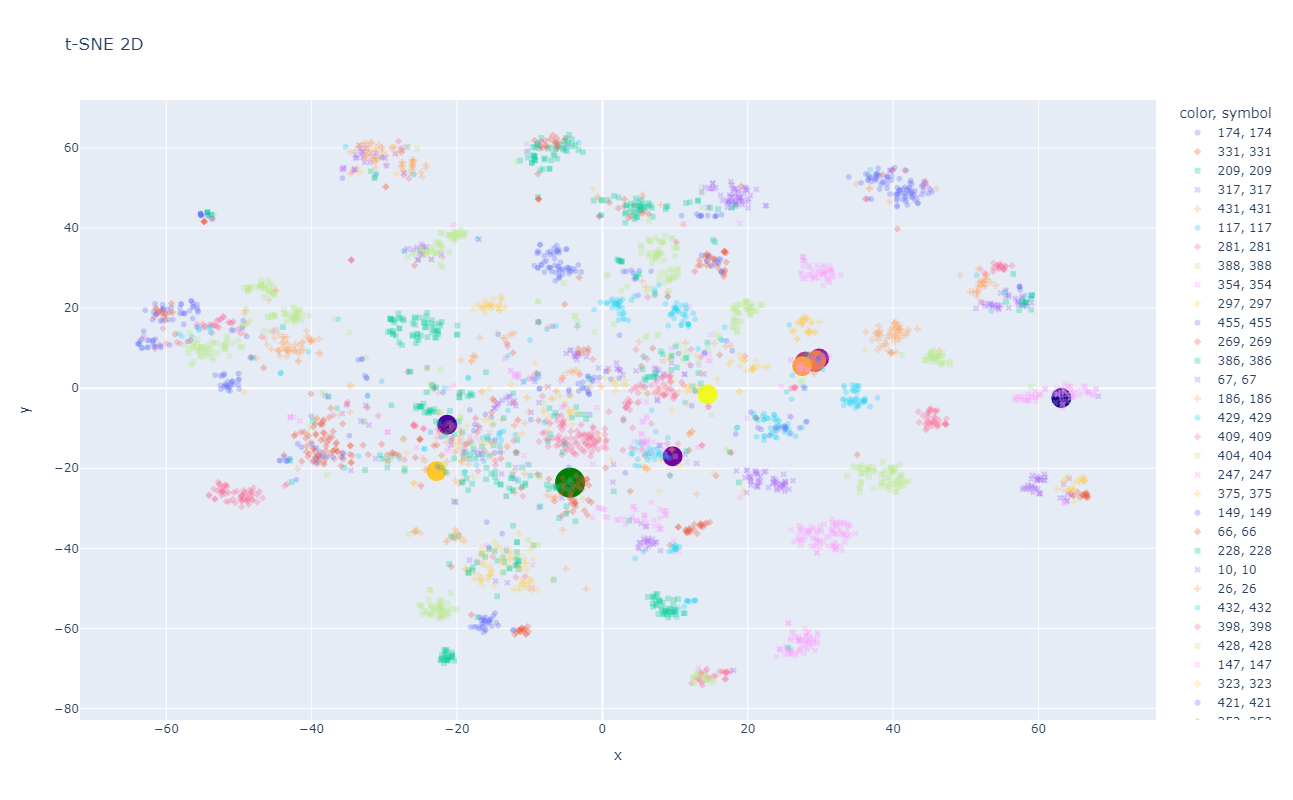

In [13]:
tsne = TSNE(n_components=2)
articles_tsne = tsne.fit_transform(
    np.concatenate((articles_sample_std, closest_articles_std, interest_std))
)

interest_tsne = articles_tsne[-1:]
articles_tsne = articles_tsne[:-1]

closest_articles_tsne = articles_tsne[-len(closest_articles) :]
articles_tsne = articles_tsne[: -len(closest_articles)]


# Plot the data in the t-SNE space
fig = px.scatter(
    x=articles_tsne[:, 0],
    y=articles_tsne[:, 1],
    color=articles_sample["category_id"],
    symbol=articles_sample["category_id"],
    title="t-SNE 2D",
    opacity=0.3,
    width=1200,
    height=800,
)
fig.add_scatter(
    x=interest_tsne[:, 0],
    y=interest_tsne[:, 1],
    mode="markers",
    marker=dict(color="green", size=30),
    text=f"User interest \n user_id: {user_id} \n category_id: {interest['category_id'].iloc[0]}",
)
fig.add_scatter(
    x=closest_articles_tsne[:, 0],
    y=closest_articles_tsne[:, 1],
    mode="markers",
    marker=dict(color=list(range(len(closest_articles_tsne))), size=20),
    text=[
        f"rank: {i} / article_id: {a.article_id} / category_id: {a.category_id}"
        for i, a in enumerate(closest_articles.itertuples())
    ],
)
fig.show()

In [14]:
users_last_click = (
    clicks.reset_index()
    .rename(columns={"index": "click_id"})
    .sort_values(by="click_timestamp")
    .groupby(["user_id"])
    .last()
)

X = get_ratings_from_clicks(clicks.drop(list(users_last_click["click_id"])))
y_true = dict(users_last_click["click_article_id"])

test_sample = random.sample(list(y_true.keys()), k=100)

In [15]:
model_baseline_only = model_baseline_only.fit(
    Dataset.load_from_df(X, reader).build_full_trainset()
)
y_pred_baseline_only = dict(
    {
        user_id: list(
            pd.DataFrame(
                [
                    (
                        lambda p: {
                            "article_id": p.iid,
                            "prediction": p.est,
                        }
                    )(model_baseline_only.predict(uid=user_id, iid=article_id))
                    for article_id in articles["article_id"]
                ],
                columns=["article_id", "prediction"],
            )
            .sort_values(by="prediction", ascending=False)
            .reset_index(drop=True)["article_id"]
        )
        for user_id in tqdm(test_sample)
    }
)

Estimating biases using als...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.88s/it]


In [16]:
model_svd = model_svd.fit(Dataset.load_from_df(X, reader).build_full_trainset())
y_pred_svd = dict(
    {
        user_id: list(
            pd.DataFrame(
                [
                    (
                        lambda p: {
                            "article_id": p.iid,
                            "prediction": p.est,
                        }
                    )(model_svd.predict(uid=user_id, iid=article_id))
                    for article_id in articles["article_id"]
                ],
                columns=["article_id", "prediction"],
            )
            .sort_values(by="prediction", ascending=False)
            .reset_index(drop=True)["article_id"]
        )
        for user_id in tqdm(test_sample)
    }
)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


In [17]:
def score_reco(y_true, y_pred):
    score = 0
    count = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.info(f"User {user_id} not found in true values")
            continue

        true_article_id = str(y_true[user_id])

        if true_article_id not in pred_article_ids:
            logging.info(
                f"Article {true_article_id} not found in predictions for user {user_id}"
            )
            continue

        rank = pred_article_ids.index(true_article_id) + 1
        score += 1 / rank
        count += 1

    # In range [0 , 1], higher is better
    return score / count


def mean_rank(y_true, y_pred):
    sum = 0
    count = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.info(f"User {user_id} not found in true values")
            continue

        true_article_id = str(y_true[user_id])

        if true_article_id not in pred_article_ids:
            logging.info(
                f"Article {true_article_id} not found in predictions for user {user_id}"
            )
            continue

        rank = pred_article_ids.index(true_article_id) + 1
        sum += rank
        count += 1

    # In range [1 , +Inf[, lower is better
    return sum / count


def mean_average_precision(y_true, y_pred, articles, k=10):
    average_precision = 0
    for user_id, pred_article_ids in y_pred.items():
        if user_id not in y_true.keys():
            logging.warning(f"User {user_id} not found in true values")
            continue

        true_category_id = articles.iloc[int(y_true[user_id])].category_id
        pred_categories = articles.iloc[
            [int(id) for id in pred_article_ids[:k]]
        ].category_id

        average_precision = (
            len(pred_categories[pred_categories == true_category_id]) / k
        )

    return average_precision / len(y_pred)

In [18]:
print(f"Score : {score_reco(y_true, y_pred_baseline_only)}")
print(f"Mean Rank : {mean_rank(y_true, y_pred_baseline_only)}")
print(
    f"Mean Average Precision : {mean_average_precision(y_true, y_pred_baseline_only, articles, k=1000)}"
)

Score : 0.0004874617371122408
Mean Rank : 5149.31
Mean Average Precision : 5e-05


In [19]:
print(f"Score : {score_reco(y_true, y_pred_svd)}")
print(f"Mean Rank : {mean_rank(y_true, y_pred_svd)}")
print(
    f"Mean Average Precision : {mean_average_precision(y_true, y_pred_svd, articles, k=1000)}"
)

Score : 5.461970483592945e-05
Mean Rank : 25184.98
Mean Average Precision : 6e-05
